# Part 1: General Preprocessing
## A Glimpse of the dataset

In [2]:
# read the data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

from causalml.inference.meta import BaseSRegressor, BaseTRegressor, BaseXRegressor, BaseRRegressor
from causalml.inference.tree import UpliftTreeClassifier, UpliftRandomForestClassifier
from causalml.dataset.regression import synthetic_data
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from causalml.propensity import ElasticNetPropensityModel
from causalml.match import NearestNeighborMatch, create_table_one

import shap
import matplotlib.pyplot as plt

from causalml.metrics import get_cumgain

import time
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split

import os
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv("/Users/zy/Documents/GitHub/League-of-Legends/high_diamond_ranked_10min.csv")

df.head()

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
Failed to import duecredit due to No module named 'duecredit'


,gameId,blueWins,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,...,redTowersDestroyed,redTotalGold,redAvgLevel,redTotalExperience,redTotalMinionsKilled,redTotalJungleMinionsKilled,redGoldDiff,redExperienceDiff,redCSPerMin,redGoldPerMin
0,4519157822,0,28,2,1,9,6,11,0,0,...,0,16567,6.8,17047,197,55,-643,8,19.7,1656.7
1,4523371949,0,12,1,0,5,5,5,0,0,...,1,17620,6.8,17438,240,52,2908,1173,24.0,1762.0
2,4521474530,0,15,0,0,7,11,4,1,1,...,0,17285,6.8,17254,203,28,1172,1033,20.3,1728.5
3,4524384067,0,43,1,0,4,5,5,1,0,...,0,16478,7.0,17961,235,47,1321,7,23.5,1647.8
4,4436033771,0,75,4,0,6,6,6,0,0,...,0,17404,7.0,18313,225,67,1004,-230,22.5,1740.4


In [3]:
# drop unnecessary columns
col_to_drop = ['gameId', 'redFirstBlood', 'redKills','blueCSPerMin','blueGoldPerMin','redDeaths','redGoldDiff','redExperienceDiff','redCSPerMin','redGoldPerMin','redTotalGold','redTotalExperience']
df = df.drop(col_to_drop, axis=1)
#'redEliteMonsters', 'redDragons', 'redCSPerMin', is killing minions matter? speed? 'blueGoldDiff',
# cs per min same as total minions killed
#'redTotalJungleMinionsKilled', may be showing how they are moving?
#Red team gold difference compared to the enemy
#feature enginner: jungle minion/total minion; wards remaining
duplicated_rows = df.duplicated().sum()

if duplicated_rows == 0:
    print('There are 0 rows that are duplicated, which means each row in the DataFrame is unique.')
    print('So that we do not need to continue processing duplicate lines')
else:
    print(f'There are {duplicated_rows} rows that are duplicated so we need to drop those {duplicated_rows} rows')
    df = df.drop_duplicates()
    print(f'After drop duplicated rows, there are {df.shape[0]} rows left')

There are 0 rows that are duplicated, which means each row in the DataFrame is unique.
So that we do not need to continue processing duplicate lines


Some feature engineering

In [4]:
df.columns

Index(['blueWins', 'blueWardsPlaced', 'blueWardsDestroyed', 'blueFirstBlood',
       'blueKills', 'blueDeaths', 'blueAssists', 'blueEliteMonsters',
       'blueDragons', 'blueHeralds', 'blueTowersDestroyed', 'blueTotalGold',
       'blueAvgLevel', 'blueTotalExperience', 'blueTotalMinionsKilled',
       'blueTotalJungleMinionsKilled', 'blueGoldDiff', 'blueExperienceDiff',
       'redWardsPlaced', 'redWardsDestroyed', 'redAssists', 'redEliteMonsters',
       'redDragons', 'redHeralds', 'redTowersDestroyed', 'redAvgLevel',
       'redTotalMinionsKilled', 'redTotalJungleMinionsKilled'],
      dtype='object')

In [5]:
df['blueHelpful'] = np.where(df['blueKills'] != 0, df['blueAssists'] / df['blueKills'], 0)
df['redHelpful'] = np.where(df['blueDeaths'] != 0, df['redAssists'] / df['blueDeaths'], 0)
#maybe hinting direction of attacking
df['blueJunglePercentage'] = df['blueTotalJungleMinionsKilled'] / df['blueTotalMinionsKilled']
df['redJunglePercentage'] = df['redTotalJungleMinionsKilled'] / df['redTotalMinionsKilled']

df['redWardsRemaining'] = df['redWardsPlaced'] - df['blueWardsDestroyed']
df['blueWardsRemaining'] = df['blueWardsPlaced'] - df['redWardsDestroyed']


## Correlation and Association

We use pytimetk to catch non-linear correlations by binning the predictors.

In [12]:
import pytimetk as tk

In [13]:
df_binarized = df.drop('blueWins',axis=1).binarize()
df_binarized['blueWins'] = df['blueWins']
df_corr = df_binarized.correlate(target='blueWins')
df_corr.plot_correlation_funnel()

## Use Case Statement
  Based on the correlation funnel, we drop several unrelated columns. It is clear that our use case is to hold down gold difference!

In [6]:
df.drop(['blueJunglePercentage','redWardsPlaced','blueWardsPlaced'],axis=1,inplace=True)# its not that the number of wards placed matters, but the number of wards remaining

In [7]:
df['blueGoldDiff'].describe()

count     9879.000000
mean        14.414111
std       2453.349179
min     -10830.000000
25%      -1585.500000
50%         14.000000
75%       1596.000000
max      11467.000000
Name: blueGoldDiff, dtype: float64

In [8]:
df['blueExperienceDiff'].describe()

count    9879.000000
mean      -33.620306
std      1920.370438
min     -9333.000000
25%     -1290.500000
50%       -28.000000
75%      1212.000000
max      8348.000000
Name: blueExperienceDiff, dtype: float64

# Part 2: Causal Inference Model

In [9]:
df['treatment'] = (df['blueGoldDiff'] > 14).astype(int) # this can be identify as adopting the strategy or not(try to get more gold in the first 10 mins than the enemy)
y = df['blueWins'].values
w = df['treatment'].values
w_multi = np.array(['treatment_A' if x==1 else 'control' for x in w])

X = df.drop(columns=['blueWins', 'treatment', 'blueGoldDiff']).values

In [10]:
# Assuming X, w_multi, and y are your features, treatment, and outcome variables, respectively
X_train, X_test, w_train, w_test, _, _, y_train, y_test = train_test_split(X, w_multi, w, y, test_size=0.2, random_state=42)

## Base Model: `LogisticRegression()`
### S Learner
Why logreg? it provides the best predictive performance for this data, it's likely that it captures the underlying relationships effectively, which is crucial for estimating causal effects.

In [27]:
# Define a list to store performance metrics for each learner
performance_metrics = []

In [28]:
# Initialize the S-Learner with a base regressor
base_algo = LogisticRegression()
slearner = BaseSRegressor(base_algo, control_name='control')

slearner.fit(X_train, w_train, y_train)
ate_slearner = slearner.estimate_ate(X_test, w_test, y_test)

# Check if the return value is a single value or a tuple
if isinstance(ate_slearner, tuple):
    performance_metrics.append({'Learner': 'S-Learner',
                                'Average Treatment Effect': ate_slearner[0],
                                'Lower Bound CI': ate_slearner[1],
                                'Upper Bound CI': ate_slearner[2]})
else:
    performance_metrics.append({'Learner': 'S-Learner',
                                'Average Treatment Effect': ate_slearner})

#### before spliting the data

In [22]:
slearner = BaseSRegressor(base_algo, control_name='control')
ate = slearner.estimate_ate(X, w_multi, y)

# Print the ATE estimate
print(f"Estimated ATE with LGBRegressor: {ate}")

Estimated ATE with LGBRegressor: [0.00172082]


### X learner with propensity score

In [29]:
# compute propensity scores ref: https://causalml.readthedocs.io/en/latest/quickstart.html#synthetic-data-generation-process
pm = ElasticNetPropensityModel(n_fold=5, random_state=42)
e = pm.fit_predict(X, w_multi)
e_multi = {'treatment_A': e}

In [30]:
# Initialize the X-Learner with propensity scores
xlearner_e = BaseXRegressor(base_algo, control_name='control')
xlearner_e.fit(X_train, w_train, y_train, p=e_multi)

ate_xlearner_e = xlearner_e.estimate_ate(X_test, w_test, y_test)

# Check if the return value is a single value or a tuple
if isinstance(ate_xlearner_e, tuple):
    performance_metrics.append({'Learner': 'X-Learner (Propensity Score)',
                                'Average Treatment Effect': ate_xlearner_e[0],
                                'Lower Bound CI': ate_xlearner_e[1],
                                'Upper Bound CI': ate_xlearner_e[2]})
else:
    performance_metrics.append({'Learner': 'X-Learner (Propensity Score)',
                                'Average Treatment Effect': ate_xlearner_e})


#### before spliting data

In [12]:
xlearner_e = BaseXRegressor(base_algo, control_name='control')
te, lb, ub = xlearner_e.estimate_ate(X, w_multi, y, p=e_multi)

print('Average Treatment Effect (BaseXRegressor using Logreg): {:.2f} ({:.2f}, {:.2f})'.format(te[0], lb[0], ub[0]))

Average Treatment Effect (BaseXRegressor using Logreg): 0.71 (0.69, 0.73)


### X learner without propensity score

In [31]:
# Initialize the X-Learner with propensity scores
xlearner = BaseXRegressor(base_algo, control_name='control')
xlearner.fit(X_train, w_train, y_train)

ate_xlearner = xlearner.estimate_ate(X_test, w_test, y_test)

# Check if the return value is a single value or a tuple
if isinstance(ate_xlearner, tuple):
    performance_metrics.append({'Learner': 'X-Learner',
                                'Average Treatment Effect': ate_xlearner[0],
                                'Lower Bound CI': ate_xlearner[1],
                                'Upper Bound CI': ate_xlearner[2]})
else:
    performance_metrics.append({'Learner': 'X-Learner',
                                'Average Treatment Effect': ate_xlearner})

### T Learner

In [32]:
tlearner = BaseTRegressor(base_algo, control_name='control')
tlearner.fit(X_train, w_train, y_train)

ate_tlearner = tlearner.estimate_ate(X_test, w_test, y_test)

# Check if the return value is a single value or a tuple
if isinstance(ate_tlearner, tuple):
    performance_metrics.append({'Learner': 'T-Learner',
                                'Average Treatment Effect': ate_tlearner[0],
                                'Lower Bound CI': ate_tlearner[1],
                                'Upper Bound CI': ate_tlearner[2]})
else:
    performance_metrics.append({'Learner': 'T-Learner',
                                'Average Treatment Effect': ate_tlearner})

#### before spliting data

In [14]:
tlearner = BaseTRegressor(base_algo, control_name='control')
te, lb, ub = tlearner.estimate_ate(X=X, treatment=w_multi, y=y)
print('Average Treatment Effect (BaseTRegressor using Logreg): {:.2f} ({:.2f}, {:.2f})'.format(te[0], lb[0], ub[0]))

Average Treatment Effect (BaseTRegressor using Logreg): 0.08 (0.06, 0.10)


### R Learner

In [33]:
# Initialize the R-Learner with a base regressor
rlearner_e = BaseTRegressor(base_algo, control_name='control')
# Fit the R-Learner
rlearner_e.fit(X_train, w_train, y_train, p=e_multi)

# Estimate ATE for the R-Learner
ate_rlearner_e = rlearner_e.estimate_ate(X_test, w_test, y_test, p=e_multi)

# Check if the return value is a single value or a tuple
if isinstance(ate_rlearner_e, tuple):
    performance_metrics.append({'Learner': 'R-Learner',
                                'Average Treatment Effect': ate_rlearner_e[0],
                                'Lower Bound CI': ate_rlearner_e[1],
                                'Upper Bound CI': ate_rlearner_e[2]})
else:
    performance_metrics.append({'Learner': 'R-Learner',
                                'Average Treatment Effect': ate_rlearner_e})

#### before spliting data

In [15]:
rlearner_e = BaseTRegressor(base_algo, control_name='control')
te, lb, ub = rlearner_e.estimate_ate(X=X, treatment=w_multi, y=y,p=e_multi)
print('Average Treatment Effect (BaseRRegressor using Logreg): {:.2f} ({:.2f}, {:.2f})'.format(te[0], lb[0], ub[0]))

Average Treatment Effect (BaseRRegressor using Logreg): 0.08 (0.06, 0.10)


### Learner comparison

In [35]:
# Convert the list of dictionaries to a DataFrame
performance_df = pd.DataFrame(performance_metrics)

# Display the performance metrics table with formatted floating-point numbers
print(performance_df.to_string(index=False, float_format="{:.4f}".format))


                     Learner Average Treatment Effect        Lower Bound CI       Upper Bound CI
                   S-Learner   [0.003036437246963563]                   NaN                  NaN
X-Learner (Propensity Score)     [0.7905079941538671]  [0.7454045149995441] [0.8356114733081901]
                   X-Learner     [0.7905079941538671]  [0.7454045149995441] [0.8356114733081901]
                   T-Learner     [0.1346153846153846] [0.08895036420476495] [0.1802804050260043]
                   R-Learner     [0.1346153846153846] [0.08895036420476495] [0.1802804050260043]


Interpretation:
- Magnitude of ATE: A higher absolute value of ATE indicates a stronger treatment effect.
- Width of Confidence Intervals: Smaller confidence intervals indicate more precise estimates. Narrower intervals imply less uncertainty in the estimated treatment effect.

As a result we want to choose the learner with the highest ATE magnitude and the narrowest confidence intervals.

In this case, it seems that the X-Learner has the highest ATE magnitude of approximately 0.79, and the confidence interval is relatively narrow compared to other learners. Therefore, we might consider the X-Learner as the best performing learner in this scenario.

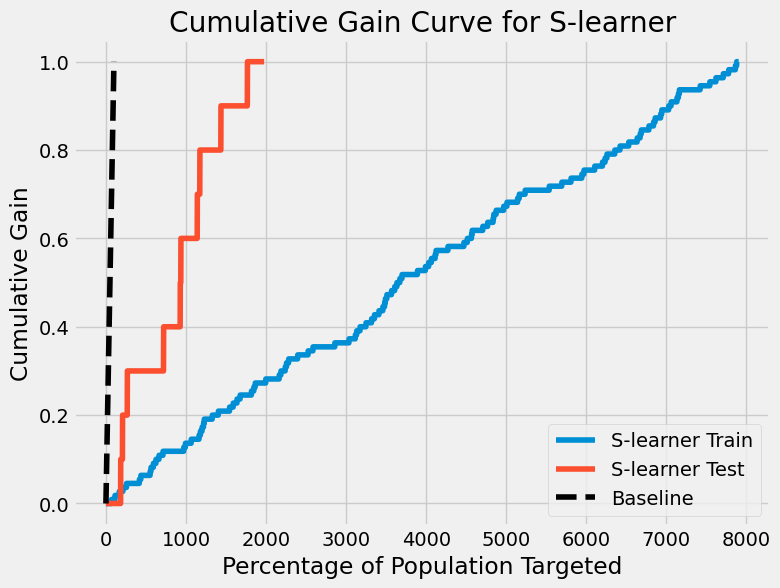

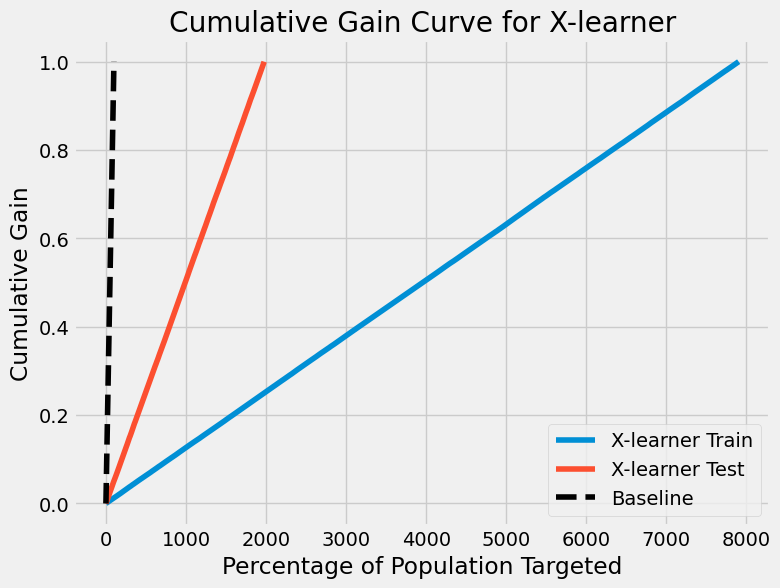

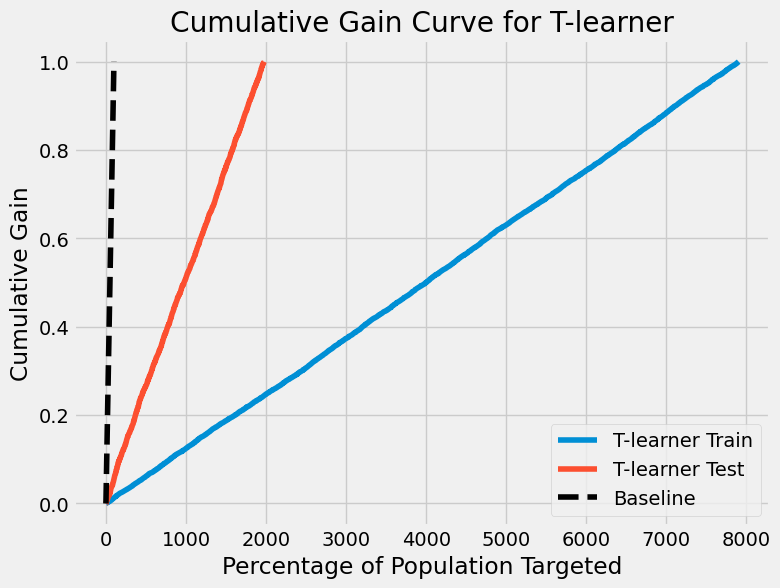

In [16]:
# Assuming X, w_multi, and y are your features, treatment, and outcome variables, respectively
X_train, X_test, w_train, w_test, w_int_train, w_int_test, y_train, y_test = train_test_split(
    X, w_multi, w, y, test_size=0.2, random_state=42)

# Define your base algorithm
base_algo = LogisticRegression()

# Initialize and fit the learners
s_learner = BaseSRegressor(base_algo, control_name='control')
x_learner = BaseXRegressor(base_algo, control_name='control')
t_learner = BaseTRegressor(base_algo, control_name='control')

learners = {'S-learner': s_learner, 'X-learner': x_learner, 'T-learner': t_learner}

# Fit the models and calculate CATE
for name, learner in learners.items():
    learner.fit(X_train, w_train, y_train)
    cate_train = learner.predict(X_train)
    cate_test = learner.predict(X_test)

    # Create DataFrames for training and test sets
    df_train = pd.DataFrame({'y': y_train, 'w': w_int_train, 'cate': cate_train.ravel()})
    df_test = pd.DataFrame({'y': y_test, 'w': w_int_test, 'cate': cate_test.ravel()})

    # Calculate cumulative gains for each learner
    cumgain_train = get_cumgain(df_train, outcome_col='y', treatment_col='w', treatment_effect_col='cate', normalize=True)
    cumgain_test = get_cumgain(df_test, outcome_col='y', treatment_col='w', treatment_effect_col='cate', normalize=True)

    # Plot cumulative gain curves
    plt.figure(figsize=(8, 6))
    plt.plot(cumgain_train, label=f'{name} Train')
    plt.plot(cumgain_test, label=f'{name} Test')
    plt.plot([0, 100], [0, 1], linestyle="--", color="black", label="Baseline")
    plt.legend()
    plt.title(f"Cumulative Gain Curve for {name}")
    plt.xlabel("Percentage of Population Targeted")
    plt.ylabel("Cumulative Gain")
    plt.show()

https://github.com/uber/causalml/blob/master/tests/test_meta_learners.py
how uber refine it. tb implemented.

In [17]:
def ape(true_value, estimate):
    return np.abs((estimate - true_value) / true_value)
ERROR_THRESHOLD = 0.05  # Adjust this value as appropriate for your use case
def evaluate_learner(learner, X_train, X_test, w_train, w_test, y_train, y_test):
    # Fit the learner to the training data
    learner.fit(X_train, w_train, y_train)
    
    # Estimate ATE on the training set
    ate_train = learner.estimate_ate(X=X_train, treatment=w_train, y=y_train)
    
    # Unpack the ATE and confidence intervals if they are returned
    if isinstance(ate_train, tuple) and len(ate_train) == 3:
        ate_train, lb_train, ub_train = ate_train
        # Assert that the estimated ATE is within the confidence interval
        assert (ate_train >= lb_train) and (ate_train <= ub_train), "ATE not within the confidence interval"
    else:
        # Set dummy confidence intervals if they are not returned
        lb_train, ub_train = ate_train, ate_train
    
    # Predict CATE for the test set
    cate_test_predictions = learner.predict(X_test)

    # Sort the test set by predicted CATE in descending order
    sorted_indices = np.argsort(-cate_test_predictions)
    sorted_cate = cate_test_predictions[sorted_indices]
    sorted_y = y_test[sorted_indices]
    sorted_w = w_test[sorted_indices]
    # Convert sorted_w to an integer array if necessary
    sorted_w = sorted_w.astype(int)
    # Compute cumulative gain
    cum_gain = np.cumsum(sorted_y[sorted_w == 1]) / np.arange(1, sum(sorted_w) + 1)

    # Check if the cumulative gain when using the model's prediction is
    # higher than it would be under random targeting
    random_gain = np.cumsum(sorted_y) / np.arange(1, len(sorted_y) + 1)
    assert cum_gain[-1] > random_gain[-1], "Model does not outperform random targeting"

    return ate_train, lb_train, ub_train, cate_test_predictions, cum_gain

# Initialize your learners
s_learner = BaseSRegressor(base_algo, control_name='control')
x_learner = BaseXRegressor(base_algo, control_name='control')
t_learner = BaseTRegressor(base_algo, control_name='control')

# Evaluate each learner
ate_s, lb_s, ub_s, cate_s_preds, cumgain_s = evaluate_learner(
    s_learner, X_train, X_test, w_train, w_test, y_train, y_test
)

ate_x, lb_x, ub_x, cate_x_preds, cumgain_x = evaluate_learner(
    x_learner, X_train, X_test, w_train, w_test, y_train, y_test
)

ate_t, lb_t, ub_t, cate_t_preds, cumgain_t = evaluate_learner(
    t_learner, X_train, X_test, w_train, w_test, y_train, y_test
)

ValueError: invalid literal for int() with base 10: 'control'

## Insights:
pretty much the same for cumulative gain; A possible reason for the discrepancy with ATE could be that the T-learner and R-learner are not capturing the heterogeneity in treatment effects as effectively as the X-learner. This could result in a lower ATE if the X-learner is better at identifying subpopulations that benefit more from the treatment.

### plot
Training Set (Blue Curve): The blue curve rises sharply at the beginning, indicating that targeting a small percentage of the population based on the T-learner's training predictions yields a large portion of the total possible gains. This suggests that the T-learner is very effective at identifying who will benefit most from the treatment in the training set.

Test Set (Red Curve): The red curve, representing the test set, is lower than the training set curve. This indicates that the model's effectiveness at predicting who will benefit from the treatment is less on unseen data. The fact that it is below the blue curve suggests some overfitting to the training data or a difference in the distribution between the training and test sets.

Baseline (Dashed Line): The baseline here likely represents the gain that would be achieved by targeting individuals randomly. Both the training and test set curves are above this line, indicating that the T-learner is performing better than random targeting.

Generalization to New Data: Since the red curve is consistently below the blue curve, this could imply that the model may not generalize as well to new data as hoped. The difference between the curves should be investigated to ensure the model is robust and not overfitting.


Move on with X learner: when choosing a model, we should consider both the ATE and the model's ability to rank individuals for targeting. Since the goal is to understand the overall impact of a treatment, a model with a higher ATE might be more informative.

In [36]:
te_train, lb_train, ub_train = xlearner.estimate_ate(X_train, w_train, y_train)

te_test, lb_test, ub_test = xlearner.estimate_ate(X_test, w_test, y_test)

# Compare the ATE estimates from the training and test sets
print(f"Estimated ATE on training set: {te_train[0]} (95% CI: {lb_train[0]}, {ub_train[0]})")
print(f"Estimated ATE on test set: {te_test[0]} (95% CI: {lb_test[0]}, {ub_test[0]})")

Estimated ATE on training set: 0.7620832636452478 (95% CI: 0.7397840845952955, 0.7843824426952001)
Estimated ATE on test set: 0.7905079941538671 (95% CI: 0.7454045149995441, 0.8356114733081901)


# Part 3: Feature Importance and Shapley Values
## Feature Importance (method = `permutation`)
Permutation importance is a model-agnostic method and is often used to get a more reliable estimate of feature importance because it accounts for interactions between features and doesn't rely on model-specific metrics. Thus, we continue with this method.

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

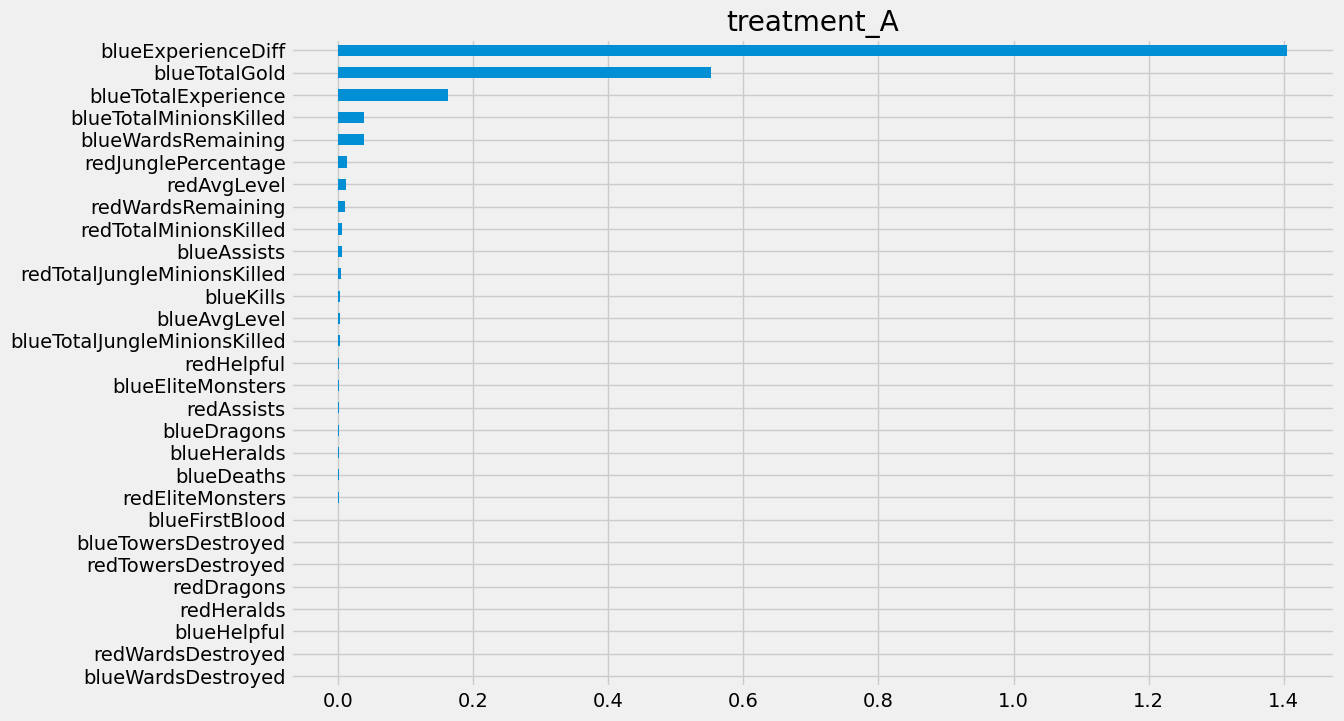

In [37]:
xlearner_tau = xlearner.predict(X, w_multi, y)
feature_name = df.drop(columns=['blueWins', 'treatment', 'blueGoldDiff']).columns
xlearner.plot_importance(X=X, 
                         tau=xlearner_tau, 
                         method='permutation', 
                         features=feature_name)


## Findings - *Feature Importance Plot*
  TO BE DONE
  
  Note: i think minions are highly correlated with gold.. good thing or bad thing? is this tactical? TOBECONFIRMED... (you get gold no matter what, but probably)


## Feature Importance (`sklearn.inspection.permutation_importance`)

In [42]:
start_time = time.time()

# Initialize the linear regression model
model_tau = LinearRegression()

# Fit the model
model_tau_fit = model_tau.fit(X, xlearner_tau)

# Calculate permutation importances
perm_imp_test = permutation_importance(
    estimator=model_tau_fit, 
    X=X, 
    y=xlearner_tau, 
    random_state=42
).importances_mean

# Create a Series with feature importances
feature_importance = pd.Series(perm_imp_test, feature_name).sort_values(ascending=False)

print("Elapsed time: %s seconds" % (time.time() - start_time))

Elapsed time: 0.4948899745941162 seconds


Text(0.5, 1.0, 'Test Set Permutation Importances')

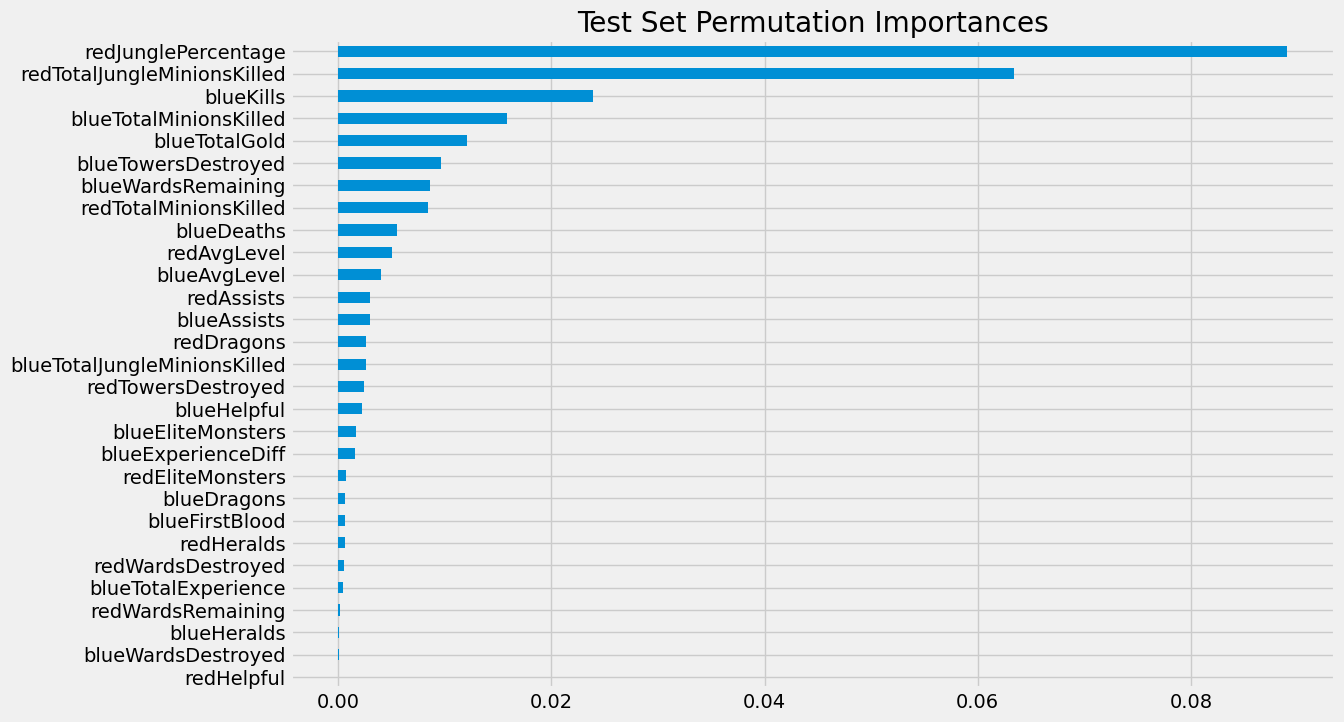

In [43]:
pd.Series(perm_imp_test, feature_name).sort_values().plot(kind='barh', figsize=(12, 8))
plt.title('Test Set Permutation Importances')

## Shapley Values

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

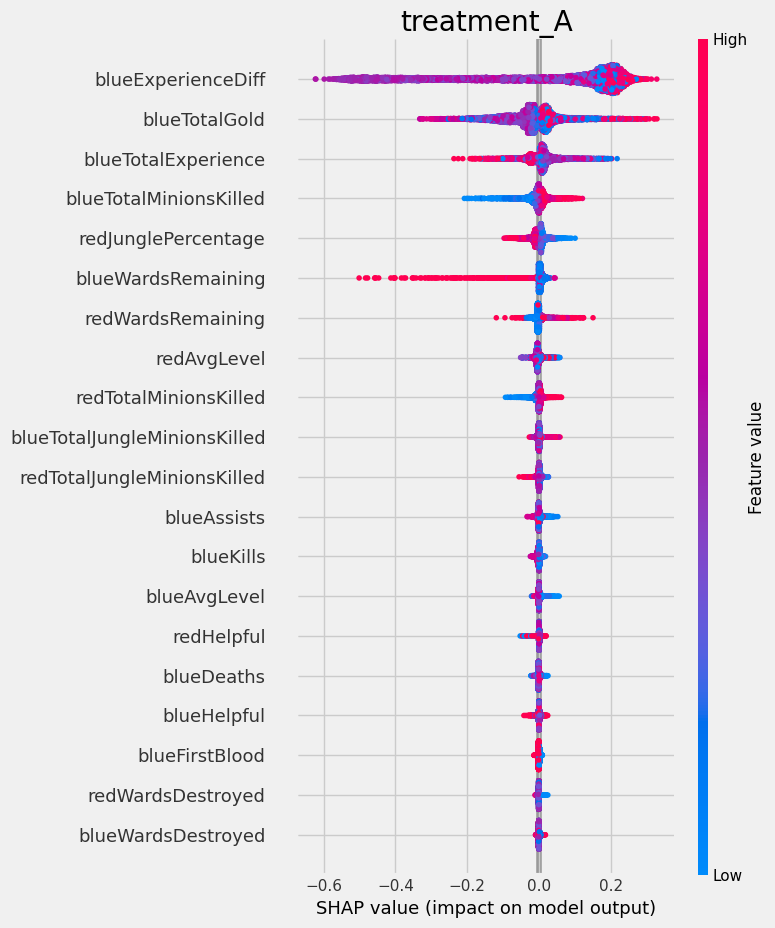

In [44]:
xlearner.plot_shap_values(X=X, tau=xlearner_tau, features=feature_name)

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

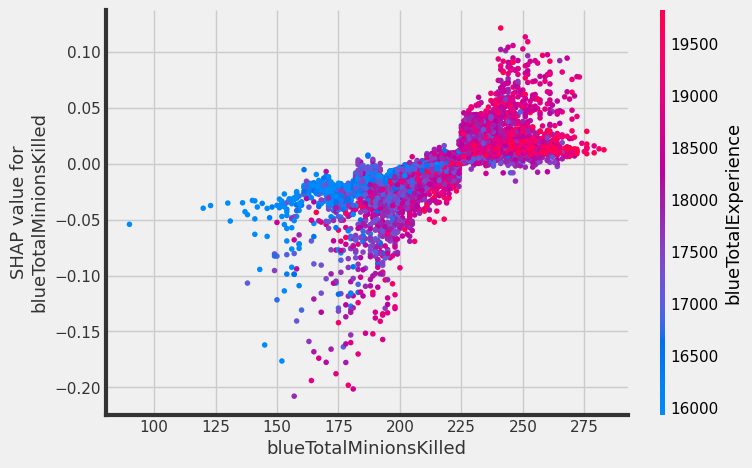

In [45]:
xlearner.plot_shap_dependence(treatment_group='treatment_A',
                              feature_idx='blueTotalMinionsKilled',
                              X=X,
                              tau=xlearner_tau,
                              interaction_idx='auto',
                              features=feature_name)